In [35]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import urllib.request
from PIL import Image

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVC



from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

import tools_tb

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("diamonds_train.csv", index_col = 0)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


In [3]:
print("shape", df.shape, "\n")

df.info()

shape (40345, 10) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40345 entries, 0 to 40344
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40345 non-null  float64
 1   cut      40345 non-null  object 
 2   color    40345 non-null  object 
 3   clarity  40345 non-null  object 
 4   depth    40345 non-null  float64
 5   table    40345 non-null  float64
 6   x        40345 non-null  float64
 7   y        40345 non-null  float64
 8   z        40345 non-null  float64
 9   price    40345 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


In [4]:
df[["cut", "color", "clarity"]].head()

,cut,color,clarity
0,Ideal,H,VS2
1,Very Good,D,VVS2
2,Premium,F,VS1
3,Ideal,H,IF
4,Good,G,SI1


In [5]:
df.describe()

,carat,depth,table,x,y,z,price
count,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000
mean,0.795652,61.750413,57.460302,5.726106,5.730217,3.535136,3924.089924
std,0.470806,1.424219,2.235333,1.118690,1.148584,0.693662,3982.000515
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,948.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2395.000000
75%,1.040000,62.500000,59.000000,6.540000,6.530000,4.030000,5313.000000
max,4.010000,79.000000,95.000000,10.020000,58.900000,8.060000,18818.000000


In [6]:
# Won't execute it because it is way to heavy

# sns.set_theme()

# pair_plot = sns.pairplot(df)

# pair_plot.savefig("pairplot.png")

### Relaciones de las variables independientes con price:
- **carat (diamong weight)**: positive and pseudo linear, maybe exponential
- **depth (depth in mm)**: this variable seems to have no clear relation. Most diamongs range between 50 and 70 mm depth, but the price could be almost any. --> `Candidate for combination with other column`
- **table (top of the diamond with relative to widest point)**: We see a similar situation as before for this variable. --> `Candidate for combination with other column`
- **x (length in mm)**: we see an exponential relation with price here (some outliers)
- **y (width in mm)**: maybe exponential, but quite close to no clear relation --> `Try both, exponential and transformation`
- **z (depth in mm)**: this one is also exponential

<AxesSubplot:>

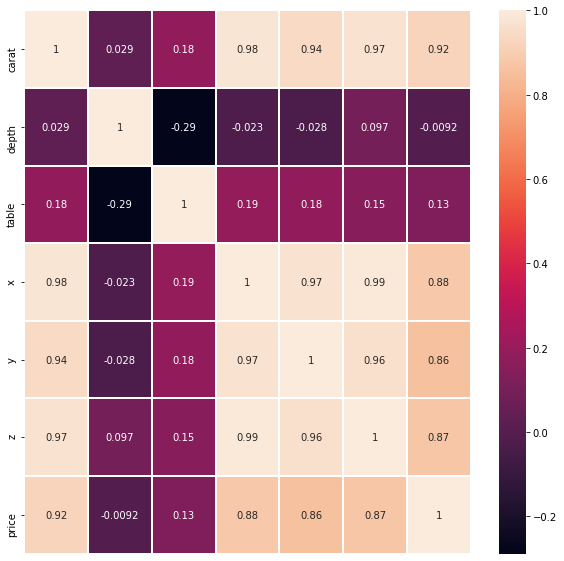

In [7]:
plt.figure(figsize = (10, 10))

sns.heatmap(df.corr(), annot = True, linewidths = .1, xticklabels = False)

Similar insights as before. The columns depth and table don't seem to have high correlation with price. We'll explore this later.

The rest of the columns are quite correlated with price.

# BASELINE MODEL

In [8]:
# Let's have a very basic initial model to start with and see what the results look like

# Independent variables -> We have to drop the categorical ones
X = df.drop(["cut", "color", "clarity", "price"], axis = 1)

# Dependent variable
y = df["price"]

# Model
baseline = LinearRegression()

In [9]:
seed = 42
split = 0.2

# Split between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = seed)

In [10]:
# Model training
baseline.fit(X_train, y_train)

# Scores
score_train = baseline.score(X_train, y_train)
score_test = baseline.score(X_test, y_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, baseline.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, baseline.predict(X_test)))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.860276004686827
RMSE = 1488.0549882636242
##################################################
Test data
Score = 0.8625397069596967
RMSE = 1477.8443181974724


Now that we have the baseline and some idea about the data, we can move into the process of improving the model and testing

# ENCODING CATEGORICAL VARIABLES

In [11]:
# Let's start with the ordinal ones, to see if they have any relation with price

# First we assign the corresponding ordinal values we want to replace the categorical ones with
cut_dict = {
    "Fair" : 1,
    "Good" : 2,
    "Very Good" : 3,
    "Premium" : 4,
    "Ideal" : 5
}

clarity_dict = {
    "I1" : 1,
    "SI2" : 2,
    "SI1" : 3,
    "VS2" : 4,
    "VS1" : 5,
    "VVS2" : 6,
    "VVS1" : 7,
    "IF" : 8
}

# Create the columns in the df for them
df["cut_encoded"] = df.cut.map(cut_dict)
df["clarity_encoded"] = df.clarity.map(clarity_dict)

df.head(5)

,carat,cut,color,clarity,depth,table,x,y,z,price,cut_encoded,clarity_encoded
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134,5,4
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532,3,6
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103,4,5
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600,5,8
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997,2,3


In [12]:
df["cut_encoded"].unique()
df["clarity_encoded"].unique()

array([4, 6, 5, 8, 3, 2, 7, 1])

In [13]:
# Now, let's do the same for the nominal variable "color"

df = pd.get_dummies(df, prefix = ["color"], columns = ["color"])
df.head()

,carat,cut,clarity,depth,table,x,y,z,price,cut_encoded,clarity_encoded,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,1.21,Ideal,VS2,63.0,57.0,6.73,6.70,4.23,6134,5,4,0,0,0,0,1,0,0
1,0.28,Very Good,VVS2,64.0,56.0,4.14,4.17,2.66,532,3,6,1,0,0,0,0,0,0
2,0.42,Premium,VS1,61.2,58.0,4.86,4.82,2.96,1103,4,5,0,0,1,0,0,0,0
3,0.26,Ideal,IF,61.1,57.0,4.16,4.12,2.53,600,5,8,0,0,0,0,1,0,0
4,1.10,Good,SI1,63.4,57.0,6.52,6.55,4.14,4997,2,3,0,0,0,1,0,0,0


<AxesSubplot:>

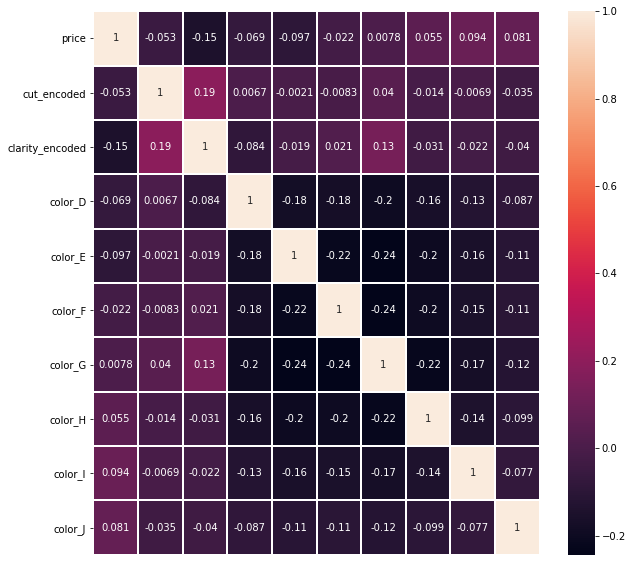

In [14]:
# Now, we are all set
# Let's see the relation between our re-defined variables and price

plt.figure(figsize = (10, 10))

df_new_variables = df.drop(["carat", "depth", "table", "x", "y", "z"], axis = 1)

sns.heatmap(df_new_variables.corr(), annot = True, linewidths = .1, xticklabels = False)

In [15]:
# Won't execute it because it is way to heavy

#sns.set_theme()

#pair_plot_encoded_variables = sns.pairplot(df_new_variables)

#pair_plot_encoded_variables.savefig("pairplot_encoded_variables.png")

El pairplor a priori nos confirma lo que la matriz de correlación. No parece que haya mucha correlación entre las variables categóricas y nuestro target (price). Aún así, vamos a probar a meterselo a nuestro baseline

# MODEL 1

In [16]:
# Let's have a very basic initial model to start with and see what the results look like

# Independent variables -> We have to drop the categorical ones
X = df.drop(["cut", "clarity", "price"], axis = 1)

# Dependent variable
y = df["price"]

# Model
model_1 = LinearRegression()

In [17]:
seed = 42
split = 0.2

# Split between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = seed)

In [18]:
# Model training
model_1.fit(X_train, y_train)

# Scores
score_train = model_1.score(X_train, y_train)
score_test = model_1.score(X_test, y_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, model_1.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, model_1.predict(X_test)))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.9109891315121202
RMSE = 1187.6952006701563
##################################################
Test data
Score = 0.9130775468328213
RMSE = 1175.1844624642072


Well, we can see quite an improvement here. Let's the slopes

In [19]:
print("column names:", X.columns)
print("coeficients:", model_1.coef_)

column names: Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_encoded',
       'clarity_encoded', 'color_D', 'color_E', 'color_F', 'color_G',
       'color_H', 'color_I', 'color_J'],
      dtype='object')
coeficients: [11184.34060564   -90.43946011   -25.85729528 -1117.35784531
    14.96034016   142.77795397   116.57620364   487.9399704
   844.68651359   630.56697206   534.18946467   296.59189136
  -185.79201579  -622.99646122 -1497.24636468]


In [20]:
for i in model_1.predict(X_test)[:30]: print(i)

6748.591111977998
3811.0396608331093
512.4009252439982
-88.23175518189419
813.2623930271766
2138.8191156859143
-1876.743427707107
-388.3376990887027
10055.273546412434
1110.2309371016727
1072.0990766914401
358.2663427123998
16682.078586076535
1210.1358872841097
427.39771116760494
7094.559387385867
6311.922223029276
3153.1488251556725
8567.957452996772
2177.242010707594
3879.1733171491464
2733.2926358197965
3477.1975141686808
2648.480536262507
1396.8951980752986
4764.248209917713
3078.508399503321
2071.648074804632
13691.396600563752
400.7832426369041


We sill get negative predictions, what makes no sense for prices.

# MODEL 2

In [21]:
# Let's standardize the data to see if we solve (at least partially) the negative values

df2 = df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price',
       'cut_encoded', 'clarity_encoded', 'color_D', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J']]
    
df2["x"] = StandardScaler().fit_transform(np.array(df2["x"]).reshape(-1, 1))
df2["y"] = StandardScaler().fit_transform(np.array(df2["y"]).reshape(-1, 1))
df2["z"] = StandardScaler().fit_transform(np.array(df2["z"]).reshape(-1, 1))
df2.head()

,carat,depth,table,x,y,z,price,cut_encoded,clarity_encoded,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,1.21,63.0,57.0,0.897395,0.844339,1.001745,6134,5,4,0,0,0,0,1,0,0
1,0.28,64.0,56.0,-1.417842,-1.358400,-1.261634,532,3,6,1,0,0,0,0,0,0
2,0.42,61.2,58.0,-0.774224,-0.792479,-0.829141,1103,4,5,0,0,1,0,0,0,0
3,0.26,61.1,57.0,-1.399964,-1.401932,-1.449047,600,5,8,0,0,0,0,1,0,0
4,1.10,63.4,57.0,0.709673,0.713742,0.871998,4997,2,3,0,0,0,1,0,0,0


In [22]:
# Now, let's try the new model

# Independent variables -> We have to drop the categorical ones
X = df2.drop(["price"], axis = 1)

# Dependent variable
y = df2["price"]

# Model
model_2 = LinearRegression()

seed = 42
split = 0.2

# Split between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = seed)

# Model training
model_2.fit(X_train, y_train)

# Scores
score_train = model_2.score(X_train, y_train)
score_test = model_2.score(X_test, y_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, model_2.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, model_2.predict(X_test)))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.9109891315121202
RMSE = 1187.6952006701563
##################################################
Test data
Score = 0.9130775468328213
RMSE = 1175.1844624642072


No effect. Time to change model

# MODEL 3

In [23]:
# Transformation
pol_transformation = PolynomialFeatures(2)
X_poly_train = pol_transformation.fit_transform(X_train, y_train)
X_poly_test = pol_transformation.fit_transform(X_test, y_test)

# Training
pol_model = LinearRegression(n_jobs = -1)
pol_model.fit(X_poly_train, y_train)

y_pred_train = pol_model.predict(X_poly_train)
y_pred_test = pol_model.predict(X_poly_test)

# Scores
score_train = r2_score(y_train, y_pred_train)
score_test = r2_score(y_test, y_pred_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.9660835678423771
RMSE = 733.1427807876252
##################################################
Test data
Score = 0.9445675047557138
RMSE = 938.4740486793133


# Model 4

In [24]:
df3 = df2[["carat", "depth", "table", "x", "y", "z", "price"]]
df3.head()

,carat,depth,table,x,y,z,price
0,1.21,63.0,57.0,0.897395,0.844339,1.001745,6134
1,0.28,64.0,56.0,-1.417842,-1.358400,-1.261634,532
2,0.42,61.2,58.0,-0.774224,-0.792479,-0.829141,1103
3,0.26,61.1,57.0,-1.399964,-1.401932,-1.449047,600
4,1.10,63.4,57.0,0.709673,0.713742,0.871998,4997


In [25]:
# Independent variables -> We have to drop the categorical ones
X = df3.drop(["price"], axis = 1)

# Dependent variable
y = df3["price"]

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = seed)

# Transformation
pol_transformation = PolynomialFeatures(2)
X_poly_train = pol_transformation.fit_transform(X_train, y_train)
X_poly_test = pol_transformation.fit_transform(X_test, y_test)


# Training
pol_model_2 = LinearRegression(n_jobs = -1)
pol_model_2.fit(X_poly_train, y_train)

y_pred_train = pol_model_2.predict(X_poly_train)
y_pred_test = pol_model_2.predict(X_poly_test)

# Scores
score_train = r2_score(y_train, y_pred_train)
score_test = r2_score(y_test, y_pred_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.8762180769281421
RMSE = 1400.5934631780676
##################################################
Test data
Score = 0.7929662507515178
RMSE = 1813.6798458118571


# Model 5

In [26]:
df = pd.read_csv("diamonds_train.csv", index_col = 0)

# Let's start with the ordinal ones, to see if they have any relation with price

# First we assign the corresponding ordinal values we want to replace the categorical ones with
cut_dict = {
    "Fair" : 1,
    "Good" : 2,
    "Very Good" : 3,
    "Premium" : 4,
    "Ideal" : 5
}

clarity_dict = {
    "I1" : 1,
    "SI2" : 2,
    "SI1" : 3,
    "VS2" : 4,
    "VS1" : 5,
    "VVS2" : 6,
    "VVS1" : 7,
    "IF" : 8
}

# Create the columns in the df for them
df["cut_encoded"] = df.cut.map(cut_dict)
df["clarity_encoded"] = df.clarity.map(clarity_dict)

# Now, let's do the same for the nominal variable "color"
df = pd.get_dummies(df, prefix = ["color"], columns = ["color"])

# Delete the old categorical independent variables
df = df.drop(["cut", "clarity"], axis = 1)
df.head()

,carat,depth,table,x,y,z,price,cut_encoded,clarity_encoded,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,1.21,63.0,57.0,6.73,6.70,4.23,6134,5,4,0,0,0,0,1,0,0
1,0.28,64.0,56.0,4.14,4.17,2.66,532,3,6,1,0,0,0,0,0,0
2,0.42,61.2,58.0,4.86,4.82,2.96,1103,4,5,0,0,1,0,0,0,0
3,0.26,61.1,57.0,4.16,4.12,2.53,600,5,8,0,0,0,0,1,0,0
4,1.10,63.4,57.0,6.52,6.55,4.14,4997,2,3,0,0,0,1,0,0,0


In [27]:
X = df.drop("price", axis = 1)
y = df["price"]

split = 0.3
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = seed)

rf = RandomForestRegressor(n_estimators = 500, random_state = seed, n_jobs = -1)

rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Scores
score_train = rf.score(X_train, y_train)
score_test = rf.score(X_test, y_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.9972984380711559
RMSE = 206.87189889669867
##################################################
Test data
Score = 0.9799791340234207
RMSE = 564.0099674411084


# Guardar datos de este último modelo

In [28]:
X_pred = pd.read_csv("diamonds_test.csv", index_col = 0)
X_pred.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.30,Ideal,H,SI2,60.0,56.0,4.41,4.43,2.65
1,0.34,Ideal,D,IF,62.1,57.0,4.52,4.46,2.79
2,1.57,Very Good,I,VS2,60.3,58.0,7.58,7.55,4.56
3,0.31,Ideal,H,VS2,61.8,57.0,4.32,4.36,2.68
4,1.51,Good,I,VVS1,64.0,60.0,7.26,7.21,4.63


In [29]:
X_pred.shape

(13449, 9)

In [30]:
X_pred["cut_encoded"] = X_pred.cut.map(cut_dict)
X_pred["clarity_encoded"] = X_pred.clarity.map(clarity_dict)

# Now, let's do the same for the nominal variable "color"
X_pred = pd.get_dummies(X_pred, prefix = ["color"], columns = ["color"])

# Delete the old categorical independent variables
X_pred = X_pred.drop(["cut", "clarity"], axis = 1)

X_pred.head()

,carat,depth,table,x,y,z,cut_encoded,clarity_encoded,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.30,60.0,56.0,4.41,4.43,2.65,5,2,0,0,0,0,1,0,0
1,0.34,62.1,57.0,4.52,4.46,2.79,5,8,1,0,0,0,0,0,0
2,1.57,60.3,58.0,7.58,7.55,4.56,3,4,0,0,0,0,0,1,0
3,0.31,61.8,57.0,4.32,4.36,2.68,5,4,0,0,0,0,1,0,0
4,1.51,64.0,60.0,7.26,7.21,4.63,2,7,0,0,0,0,0,1,0


In [31]:
predictions_submit = rf.predict(X_pred)
predictions_submit

array([  448.894,  1814.588,  9609.654, ..., 14608.588, 10209.02 ,
         738.012])

In [32]:
submission = pd.DataFrame({"id": range(len(predictions_submit)), "price": predictions_submit})
submission.head()

,id,price
0,0,448.894
1,1,1814.588
2,2,9609.654
3,3,494.048
4,4,8662.496


In [33]:
tools_tb.chequeator(submission)

You're ready to submit!


# Model 6

In [50]:
df = pd.read_csv("diamonds_train.csv", index_col = 0)

# Let's start with the ordinal ones, to see if they have any relation with price

# First we assign the corresponding ordinal values we want to replace the categorical ones with
cut_dict = {
    "Fair" : 1,
    "Good" : 2,
    "Very Good" : 3,
    "Premium" : 4,
    "Ideal" : 5
}

clarity_dict = {
    "I1" : 1,
    "SI2" : 2,
    "SI1" : 3,
    "VS2" : 4,
    "VS1" : 5,
    "VVS2" : 6,
    "VVS1" : 7,
    "IF" : 8
}

# Create the columns in the df for them
df["cut_encoded"] = df.cut.map(cut_dict)
df["clarity_encoded"] = df.clarity.map(clarity_dict)

# Now, let's do the same for the nominal variable "color"
df = pd.get_dummies(df, prefix = ["color"], columns = ["color"])

# Delete the old categorical independent variables
df = df.drop(["cut", "clarity"], axis = 1)

for column in ['carat', 'depth', 'table', 'x', 'y', 'z']:
    df[column] = StandardScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

X = df.drop("price", axis = 1)
#X = StandardScaler().fit_transform(X)
y = df["price"]

In [52]:
#####################
split = 0.3
seed = 42
iterations = 10000
C = 10000
#####################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = seed)

svr = SVR(kernel = "rbf", C = C, gamma = 0.1, epsilon = 0.1, max_iter = iterations)

svr.fit(X_train, y_train)

y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

# Scores
score_train = svr.score(X_train, y_train)
score_test = svr.score(X_test, y_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train data\nScore = {score_train}\nRMSE = {rmse_train}")
print("#" * 50)
print(f"Test data\nScore = {score_test}\nRMSE = {rmse_test}")

Train data
Score = 0.9805129809462161
RMSE = 555.6057633410654
##################################################
Test data
Score = 0.9764546625254606
RMSE = 611.6427181891751
